In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import load_model
import numpy

                               Open      High       Low     Close     Volume  \
Date                                                                           
1980-12-12 00:00:00-05:00  0.098726  0.099155  0.098726  0.098726  469033600   
1980-12-15 00:00:00-05:00  0.094005  0.094005  0.093575  0.093575  175884800   
1980-12-16 00:00:00-05:00  0.087136  0.087136  0.086707  0.086707  105728000   
1980-12-17 00:00:00-05:00  0.088853  0.089282  0.088853  0.088853   86441600   
1980-12-18 00:00:00-05:00  0.091429  0.091858  0.091429  0.091429   73449600   

                           Dividends  Stock Splits  
Date                                                
1980-12-12 00:00:00-05:00        0.0           0.0  
1980-12-15 00:00:00-05:00        0.0           0.0  
1980-12-16 00:00:00-05:00        0.0           0.0  
1980-12-17 00:00:00-05:00        0.0           0.0  
1980-12-18 00:00:00-05:00        0.0           0.0  
                              Close     Volume
Date                 

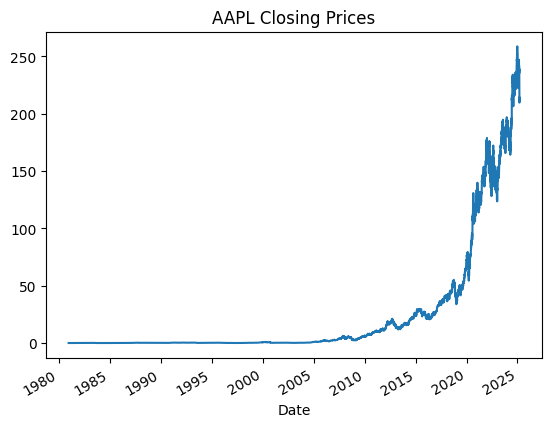

In [2]:
# Define el nombre del stock que deseas analizar
stock_name = "AAPL"  # Ejemplo con Nvidia, pero puedes elegir cualquier otro

# Obtiene los datos históricos
dataset = yf.Ticker(stock_name).history(period="max")

# Muestra las primeras entradas del dataset
print(dataset.head())

# Seleccionamos solo las columnas de cierre y volumen
data = dataset[['Close', 'Volume']]
print(data.head())

# Graficamos los precios de cierre
data['Close'].plot()
plt.title(f"{stock_name} Closing Prices")
plt.show()


In [3]:
# Usar ffill sin inplace para evitar SettingWithCopyWarning y asignar el resultado a data
data = data.ffill()

# Escalar 'Close' y 'Volume' con MinMaxScaler y asignar con loc para evitar problemas de tipos
scaler = MinMaxScaler()
data.loc[:, 'Close'] = scaler.fit_transform(data[['Close']].astype(float))
data.loc[:, 'Volume'] = scaler.fit_transform(data[['Volume']].astype(float))  # Convertir a float explícitamente

# Mostrar los datos normalizados
print(data.head())

                              Close    Volume
Date                                         
1980-12-12 00:00:00-05:00  0.000236  0.063198
1980-12-15 00:00:00-05:00  0.000216  0.023699
1980-12-16 00:00:00-05:00  0.000189  0.014246
1980-12-17 00:00:00-05:00  0.000197  0.011647
1980-12-18 00:00:00-05:00  0.000207  0.009897


C:\Users\soyun\AppData\Local\Temp\ipykernel_11720\1570816400.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0631981  0.02369891 0.01424591 ... 0.00826883 0.00809896 0.00647746]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, 'Volume'] = scaler.fit_transform(data[['Volume']].astype(float))  # Convertir a float explícitamente


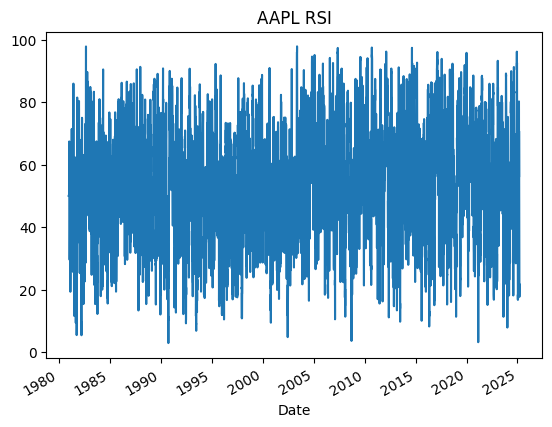

In [4]:
# Cálculo del RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi.fillna(50)  # Inicializa el primer RSI a 50

# Visualizar el RSI
data['RSI'].plot()
plt.title(f"{stock_name} RSI")
plt.show()


In [5]:
import random
import numpy as np
from collections import deque
import tensorflow as tf

class AI_Trader():
    def __init__(self, state_size, action_space=3, model_name="AITrader"):
        # Estados: Mantenerse (0), Comprar (1), Vender (2)
        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen=2000)
        self.inventory = []
        self.model_name = model_name

        # Parámetros del modelo
        self.gamma = 0.95  # Factor de descuento
        self.epsilon = 1.0  # Tasa de exploración inicial
        self.epsilon_final = 0.01  # Tasa de exploración mínima
        self.epsilon_decay = 0.995  # Factor de decaimiento de epsilon
        self.model = self.model_builder()

    def model_builder(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=128, activation='relu'),
            tf.keras.layers.Dense(units=self.action_space, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        # Ejemplo de predicción (asegúrate de que 'next_state' tiene la forma correcta)
        actions = self.model.predict(next_state.reshape(1, -1))

        return np.argmax(actions[0])

    def batch_train(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            else:
                target = reward
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay


In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def state_creator(data, timestep, window_size):
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep + 1]
    else:
        windowed_data = -starting_id * [data[0]] + list(data[0:timestep + 1])

    # Asegúrate de que sólo tomas 'window_size - 1' diferencias
    state = [(windowed_data[i + 1] - windowed_data[i]) / windowed_data[i] if windowed_data[i] != 0 else 0 for i in range(window_size - 1)]
    return np.array([state])


### Parte 3

In [7]:
import numpy as np
from tqdm import tqdm

# Configuración de parámetros del entrenamiento
episodes = 100  # Define el número de episodios de entrenamiento
batch_size = 32  # Tamaño del lote para el entrenamiento

# Crear una instancia del AI Trader
window_size = 10
state_size = window_size - 1  # Esto debería ser 9, basado en tu descripción anterior
trader = AI_Trader(state_size)

# Preparación del conjunto de datos
data_samples = len(data) - 1  # Total de muestras de datos disponibles para el entrenamiento, asumiendo 'data' es tu DataFrame


c:\Users\soyun\anaconda3\envs\aprendizaje\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Iniciar el bucle de entrenamiento
for episode in range(1, episodes + 1):
    print(f"Episodio: {episode}/{episodes}")
    trader.inventory = []
    state = state_creator(data['Close'].values, 0, window_size + 1)

    total_profit = 0

    for t in tqdm(range(data_samples)):
        action = trader.trade(state)
        next_state = state_creator(data['Close'].values, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # Compra
            trader.inventory.append(data['Close'].values[t])
            print("AI Trader compró: $", format(data['Close'].values[t], '.2f'))

        elif action == 2 and len(trader.inventory) > 0:  # Venta
            buy_price = trader.inventory.pop(0)
            reward = max(data['Close'].values[t] - buy_price, 0)
            total_profit += data['Close'].values[t] - buy_price
            print("AI Trader vendió: $", format(data['Close'].values[t], '.2f'), " Beneficio: $", format(data['Close'].values[t] - buy_price, '.2f'))

        done = t == data_samples - 1  # Si llegamos al final de los datos
        trader.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("########################")
            print("BENEFICIO TOTAL: $", format(total_profit, '.2f'))
            print("########################")

        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)

    # Guardar el modelo cada 10 episodios
    if episode % 10 == 0:
        trader.model.save(f"ai_trader_{episode}.h5")

Episodio: 1/100


  0%|          | 32/11154 [00:00<00:13, 803.97it/s]


AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader compró: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader compró: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ -0.00
AI Trader compró: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ -0.00
AI Trader vendió: $ 0.00  Beneficio: $ -0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader vendió: $ 0.00  Beneficio: $ 0.00
AI Trader compró: $ 0.00


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (1, 10)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 10), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Verificación de los primeros valores de precios para asegurarse de que se cargan correctamente
print("Verificación de los primeros precios de cierre:")
print(data['Close'].head())

# Verificación del primer estado creado para entender qué está viendo el modelo
initial_state = state_creator(data['Close'].values, 0, window_size + 1)
print("Primer estado generado para el modelo:")
print(initial_state)


Verificación de los primeros precios de cierre:
Date
1980-12-12 00:00:00-05:00    0.000236
1980-12-15 00:00:00-05:00    0.000216
1980-12-16 00:00:00-05:00    0.000189
1980-12-17 00:00:00-05:00    0.000197
1980-12-18 00:00:00-05:00    0.000207
Name: Close, dtype: float64
Primer estado generado para el modelo:
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
